https://arxiv.org/abs/2403.14403

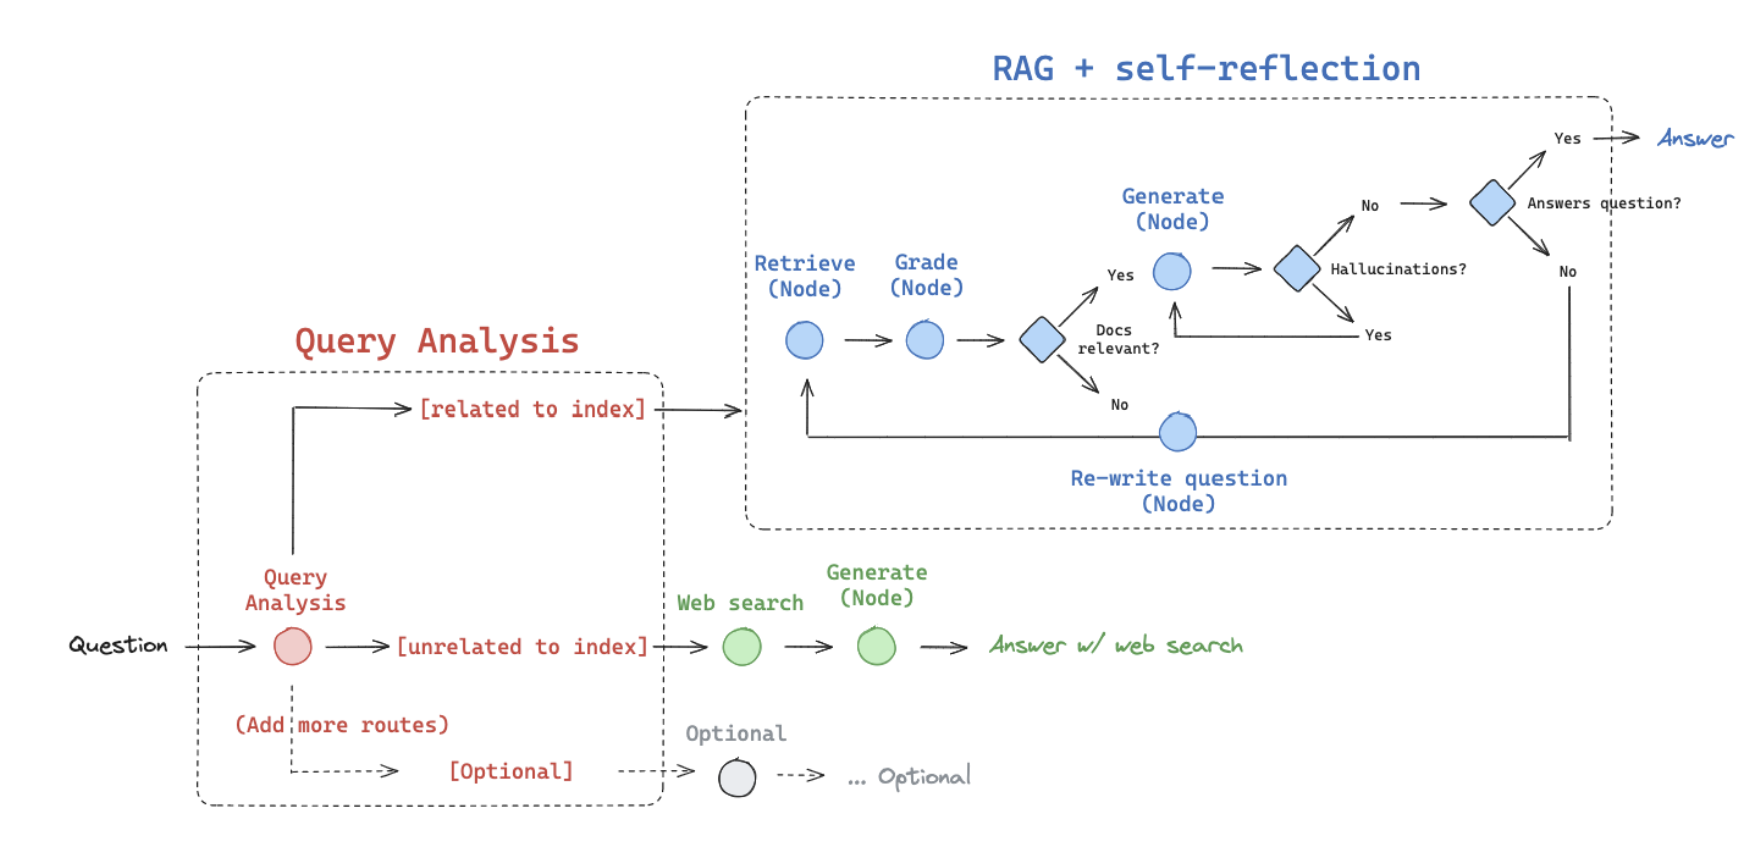

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [3]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    query = state['query']
    results = tavily_search_tool.invoke(query)
    print(f"web search results == {results}")
    return {'context': results}



In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def web_generate(state: AgentState) -> AgentState:
    context = state['context']  
    query = state['query']      
    
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  


/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- 간단한 질문에 답변을 하는 경우 작은 모델을 활용 -> 비용 저감, 답변 생성 속도 향상


In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model='gpt-4o-mini')

def basic_generate(state: AgentState) -> AgentState:
    query = state['query']
    basic_llm_chain = basic_llm | StrOutputParser()
    llm_response = basic_llm_chain.invoke(query)
    return {'answer': llm_response}


- 사용자의 질문이 들어오면 `router` 노드에서 사용자의 질문을 분석해서 적절한 노드로 이동
    - 사용자의 질문에 관한 내용이 `vector store`에 있는 경우 `income_tax_agent` 노드로 이동
    - 사용자의 질문이 간단한 경우 `basic_generate` 노드로 이동
    - 사용자의 질문이 웹 검색을 통해 답변을 얻을 수 있는 경우 `web_search` 노드로 이동

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal["vector_store", "llm", "web_search"] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to "vector_store", "llm" or "web_search"
"vector_store" contains information about income tax up to December 2024.
if you think the question is simple enough, use "llm"
if you think you need to search the web to answer the question, use "web_search"
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", "{query}"),
])

router_llm = ChatOpenAI(model='gpt-4o-mini')
structured_router_llm = router_llm.with_structured_output(Route)    # 정해진 답변만 하도록 지정 (Pydantic 객체 전달)

def router(state: AgentState) -> AgentState:
    query = state['query']
    router_chain = router_prompt | structured_router_llm    # Route 객체를 반환하므로 StrOutputParser() 사용 불가
    route = router_chain.invoke({'query': query})
    print(f"router route == {route}")
    print(f"route.target == {route.target}")
    return route.target


In [7]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node("income_tax_agent", income_tax_subgraph)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("basic_generate", basic_generate)
graph_builder.add_node("web_generate", web_generate)

/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


document start
[전문개정 2014. 1. 1.]
제56조 세액의 계산
<개정 2009. 12. 31.>  
제1관 세율
<개정 2009. 12. 31.>
제55조(세율)
거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.> 
| 종합소득           | 세    목                                          |
|------------------|--------------------------------------------------|
| 1,400만원 이하    | 과세표준의 6세부세트                               |
| 1,400만원 초과    | 84만원 + (1,400만원을 초과하는 금액의 15세부세트) |
| 5,000만원 이하    | 624만원 + (5,000만원을 초과하는 금액의 24세부세트) |
| 8,800만원 이하    | 1,536만원 + (8,800만원을 초과하는 금액의 35세부세트) |
| 1억5천만원 이하   | 3,706만원 + (1억5천만원을 초과하는 금액의 38세부세트) |
| 3억 원 이상       | 9,406만원 + (3억원을 초과하는 금액의 40세부세트) |
| 5억 원 이하       | 1억7,406만원 + (5억원을 초과하는 금액의 42세부세트) |
| 10억 원 이상      | 3억6,406만원 + (10억원을 초과하는 금액의 45세부세트) |
법제처 35
국가법령정보센터
소 트 실 변
② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 "퇴직소득 산출세액"이라 한다.)으로 한다. <개정> 2013. 1. 1, 2014. 12. 23.>
1. 해혼 사망기간의 퇴직소득국세

/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


answer == {'answer': '연봉이 5천만원인 거주자의 소득세는 624만원입니다.'}


In [8]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        "vector_store": "income_tax_agent",
        "llm": "basic_generate",
        "web_search": "web_search",
    }
)
graph_builder.add_edge("web_search", "web_generate")
graph_builder.add_edge("basic_generate", END)
graph_builder.add_edge("web_generate", END)
graph_builder.add_edge("income_tax_agent", END)


In [9]:
graph = graph_builder.compile()

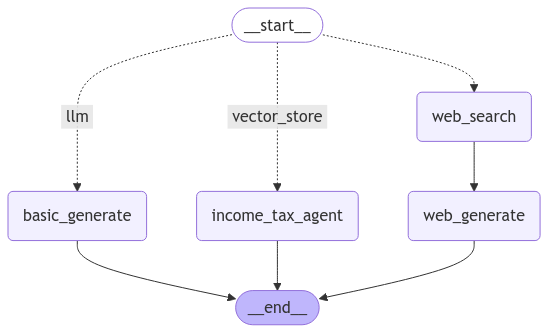

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
initial_state = {"query": "대한민국의 수도는 어디인가요?"}
graph.invoke(initial_state)

router route == target='llm'
route.target == llm


{'query': '대한민국의 수도는 어디인가요?', 'answer': '대한민국의 수도는 서울입니다.'}

In [13]:
initial_state = {"query": "연봉이 5천만원인 거주자의 소득세는 얼마인가요?"}
graph.invoke(initial_state)

router route == target='vector_store'
route.target == vector_store
helpfulness response : {'Score': 1, 'Explanation': 'The QUESTION asks for the amount of income tax for a resident with an annual salary of 50 million won. The STUDENT ANSWER provides this information clearly by stating that the income tax is 6.24 million won. Additionally, the student mentions that this amount is calculated according to the tax rate for income below 50 million won, which is relevant contextual information. Therefore, the answer is concise, relevant, and helps to answer the question correctly, meeting all the criteria.'}


{'query': '연봉이 5천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='21eb49d8-11d2-4b4f-b03b-0780eea295ec', metadata={'source': './documents/income_tax.txt'}, page_content='[전문개정 2014. 1. 1.]\n제56조 세액의 계산\n<개정 2009. 12. 31.>  \n제1관 세율\n<개정 2009. 12. 31.>\n제55조(세율)\n거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.> \n| 종합소득           | 세    목                                          |\n|------------------|--------------------------------------------------|\n| 1,400만원 이하    | 과세표준의 6세부세트                               |\n| 1,400만원 초과    | 84만원 + (1,400만원을 초과하는 금액의 15세부세트) |\n| 5,000만원 이하    | 624만원 + (5,000만원을 초과하는 금액의 24세부세트) |\n| 8,800만원 이하    | 1,536만원 + (8,800만원을 초과하는 금액의 35세부세트) |\n| 1억5천만원 이하   | 3,706만원 + (1억5천만원을 초과하는 금액의 38세부세트) |\n| 3억 원 이상       | 9,406만원 + (3억원을 초과하는 금액의 40세부세트) |\n| 5억 원 이하       | 1억7,406만원 + (5억원을 초과하는 금액의 42세부세트) |\n| 10억 원 이상      | 3억6,406만원 + 

In [14]:
initial_state = {"query": "삼성역 맛집 추천해줘"}
graph.invoke(initial_state)


router route == target='web_search'
route.target == web_search
web search results == [{'url': 'https://blog.naver.com/PostView.naver?blogId=incline98740&logNo=223615975311', 'content': "역삼역 맛집은 다양한 종류와 가격대로 선택의 폭이 넓어, 어떤 음식을 좋아하는지, 어떤 분위기에서 식사를 하고 싶은지에 따라 선택할 수 있는 장점이 있습니다. 역삼역 1번 출구에서 도보 5분 거리에 위치한 '본가'는 푸짐한 한상차림과 저렴한 가격으로 직장인들에게 인기 있는 곳입니다. 역삼역 2번 출구에서 도보 3분 거리에 위치한 '돈까스클럽'은 옛날 방식으로 만든 수제 돈까스를 저렴한 가격에 즐길 수 있는 곳입니다. 역삼역 3번 출구에서 도보 2분 거리에 위치한 '포베이'는 깔끔하고 시원한 쌀국수를 맛볼 수 있는 곳입니다. 이 글에서는 역삼역에서 회식 장소를 고민하는 분들을 위해 다양한 취향과 예산을 만족시키는 회식 맛집 TOP 5를 추천합니다. 다양한 부위의 고기와 곁들임 메뉴를 즐길 수 있으며, 특히 _는 씹는 즐거움과 풍부한 풍미를 선사합니다. 아늑하고 편안한 분위기 속에서 다양한 종류의 와인과 함께 맛있는 안주를 즐길 수 있으며 조용한 대화를 나누기에도 좋습니다."}, {'url': 'https://forourtour.com/역삼동-맛집/', 'content': '역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 국내 맛집 역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 관련 검색어에는 서울 역삼동 맛집 추천 베스트 한식 일식 술집 점심 저녁 핫플 역삼역 강남역 센터필드 데이트 놀거리 지도 음식점 분위기 재방문 리뷰 리스트 입니다. 역삼동 맛집 추천 모음 호보식당: 역삼역 핫플 마늘갈비 추천 맛집 – 홈페이지 바로가기 이 곳의 대표 메뉴인 마늘갈비는 마늘 양념이 잔뜩 올라간 

{'query': '역삼역 맛집 추천해줘',
 'context': [{'url': 'https://blog.naver.com/PostView.naver?blogId=incline98740&logNo=223615975311',
   'content': "역삼역 맛집은 다양한 종류와 가격대로 선택의 폭이 넓어, 어떤 음식을 좋아하는지, 어떤 분위기에서 식사를 하고 싶은지에 따라 선택할 수 있는 장점이 있습니다. 역삼역 1번 출구에서 도보 5분 거리에 위치한 '본가'는 푸짐한 한상차림과 저렴한 가격으로 직장인들에게 인기 있는 곳입니다. 역삼역 2번 출구에서 도보 3분 거리에 위치한 '돈까스클럽'은 옛날 방식으로 만든 수제 돈까스를 저렴한 가격에 즐길 수 있는 곳입니다. 역삼역 3번 출구에서 도보 2분 거리에 위치한 '포베이'는 깔끔하고 시원한 쌀국수를 맛볼 수 있는 곳입니다. 이 글에서는 역삼역에서 회식 장소를 고민하는 분들을 위해 다양한 취향과 예산을 만족시키는 회식 맛집 TOP 5를 추천합니다. 다양한 부위의 고기와 곁들임 메뉴를 즐길 수 있으며, 특히 _는 씹는 즐거움과 풍부한 풍미를 선사합니다. 아늑하고 편안한 분위기 속에서 다양한 종류의 와인과 함께 맛있는 안주를 즐길 수 있으며 조용한 대화를 나누기에도 좋습니다."},
  {'url': 'https://forourtour.com/역삼동-맛집/',
   'content': '역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 국내 맛집 역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플 관련 검색어에는 서울 역삼동 맛집 추천 베스트 한식 일식 술집 점심 저녁 핫플 역삼역 강남역 센터필드 데이트 놀거리 지도 음식점 분위기 재방문 리뷰 리스트 입니다. 역삼동 맛집 추천 모음 호보식당: 역삼역 핫플 마늘갈비 추천 맛집 – 홈페이지 바로가기 이 곳의 대표 메뉴인 마늘갈비는 마늘 양념이 잔뜩 올라간 갈비로, 바질, 할라피뇨, 고수로 만든 특제 소스 조합으로 함께 먹으면 